In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Entendendo o dataset
https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


In [1]:
import tensorflow as tf
import pathlib
import PIL
import numpy as np

In [13]:
data_dir=pathlib.Path('/content/drive/MyDrive/APPs/feijao/train')

In [14]:
len(list(data_dir.glob('*/*.jpg')))

1034

In [15]:
mancha = list(data_dir.glob('angular_leaf_spot/*'))

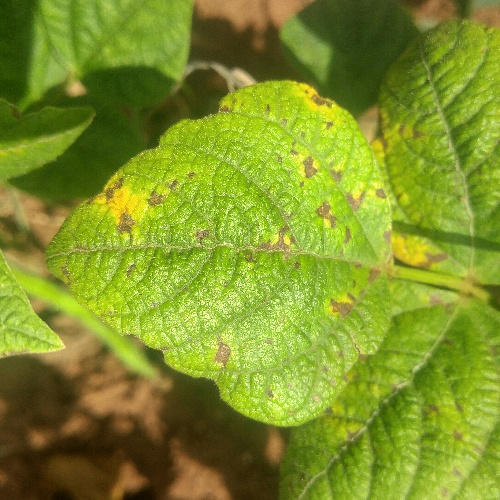

In [16]:
PIL.Image.open(str(mancha[0]))

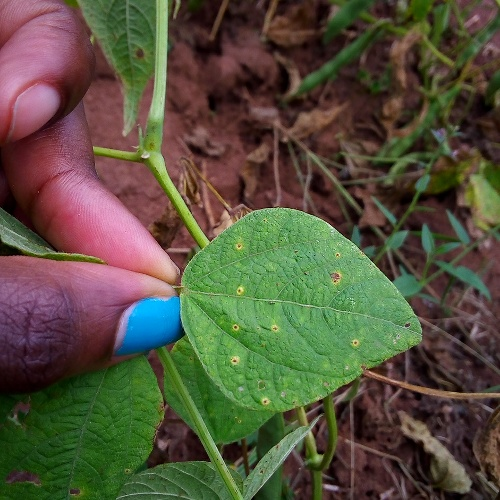

In [17]:
ferrugem = list(data_dir.glob('bean_rust/*'))
PIL.Image.open(str(ferrugem[0]))

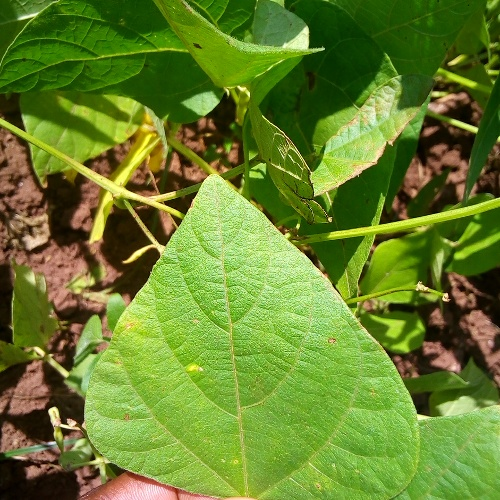

In [18]:
saudavel = list(data_dir.glob('healthy/*'))
PIL.Image.open(str(saudavel[0]))

# Carregando as imagens

In [19]:
batch_size = 32
altura = 500
largura = 500

In [20]:
treino = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(altura,largura),
    batch_size=batch_size
)

Found 1034 files belonging to 3 classes.
Using 828 files for training.


In [21]:
validacao = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(altura,largura),
    batch_size=batch_size
)

Found 1034 files belonging to 3 classes.
Using 206 files for validation.


In [22]:
nome_classes = treino.class_names
nome_classes

['angular_leaf_spot', 'bean_rust', 'healthy']

In [23]:
import matplotlib.pyplot as plt

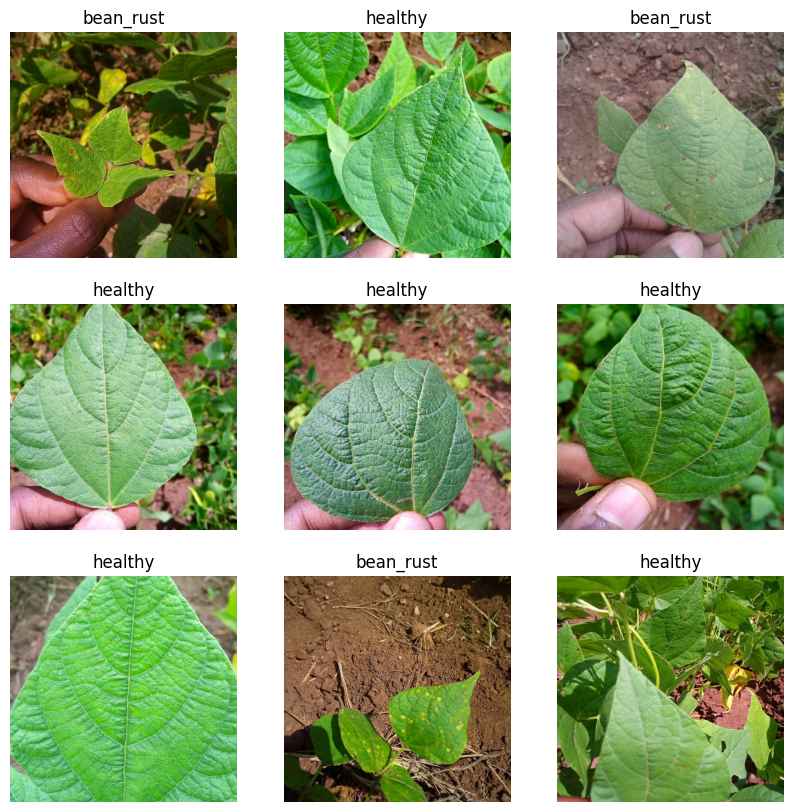

In [24]:
plt.figure(figsize=(10, 10))
for imagens, labels in treino.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imagens[i].numpy().astype("uint8"))
    plt.title(nome_classes[labels[i]])
    plt.axis("off")

# Configurando o desempenho

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

treino = treino.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validacao = validacao.cache().prefetch(buffer_size=AUTOTUNE)

# Padronização dos dados

In [26]:
camada_normalizacao = tf.keras.layers.Rescaling(1./255)

In [27]:
normalizado = treino.map(lambda x, y: (camada_normalizacao(x), y))
lote_de_imagens, lote_de_rotulos = next(iter(normalizado))
primeira_imagem = lote_de_imagens[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(primeira_imagem), np.max(primeira_imagem))

0.0 1.0


# Aumento de dados

In [28]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(altura,
                                  largura,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

# Construção do modelo

In [29]:
num_classes = len(nome_classes)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 500, 500, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 250, 250, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 125, 32)      0         
 g2D)                                                 

# Treino

In [32]:
epochs =10

history = model.fit(
    treino,
    validation_data=validacao,
    epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 39s 1s/step - loss: 2.0361 - accuracy: 0.4396 - val_loss: 0.8653 - val_accuracy: 0.5388
Epoch 2/10
26/26 [==============================] - 6s 239ms/step - loss: 0.8667 - accuracy: 0.5785 - val_loss: 0.7084 - val_accuracy: 0.6942
Epoch 3/10
26/26 [==============================] - 6s 237ms/step - loss: 0.7584 - accuracy: 0.6606 - val_loss: 0.7387 - val_accuracy: 0.6796
Epoch 4/10
26/26 [==============================] - 6s 242ms/step - loss: 0.7086 - accuracy: 0.6824 - val_loss: 0.7003 - val_accuracy: 0.6505
Epoch 5/10
26/26 [==============================] - 7s 251ms/step - loss: 0.7271 - accuracy: 0.6836 - val_loss: 0.6294 - val_accuracy: 0.7184
Epoch 6/10
26/26 [==============================] - 6s 242ms/step - loss: 0.6499 - accuracy: 0.7198 - val_loss: 0.6609 - val_accuracy: 0.7087
Epoch 7/10
26/26 [==============================] - 6s 240ms/step - loss: 0.6272 - accuracy: 0.7258 - val_loss: 0.6108 - val_accuracy: 0.7282
Epoch 8/

# Resultado do treino

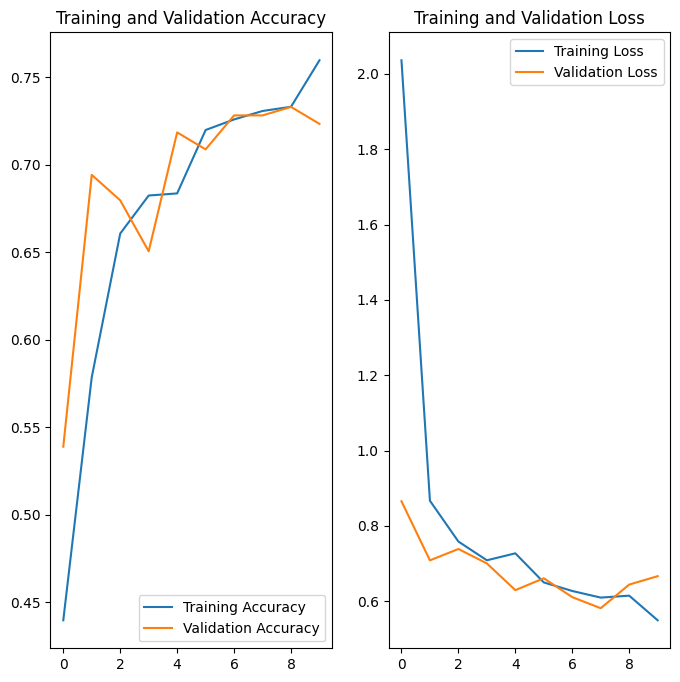

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
model.save('model_name.keras')